In [1]:
#Instalar librerias

!pip -q install kaggle opencv-python scikit-learn matplotlib tqdm


# Task
Extract and preprocess facial images from the dataset, converting them to grayscale, resizing them to a uniform dimension (e.g., 128x128 pixels), and detecting faces using a pre-trained classifier. Save the detected and cropped facial regions along with their corresponding emotional labels for subsequent model training.

## Cargar y Preprocesar Imágenes

### Subtask:
Cargar las imágenes del dataset, convertirlas a escala de grises y redimensionarlas a una dimensión uniforme (por ejemplo, 128x128 píxeles) para asegurar la consistencia. También se preparará una estructura para almacenar las etiquetas emocionales asociadas a cada imagen.


**Reasoning**:
The subtask requires loading, preprocessing (grayscale, resize), and labeling images. This code block will perform all these operations in sequence, starting with importing necessary libraries, defining parameters, and then iterating through the dataset structure to process each image and store it with its corresponding label.



In [7]:
import os
import cv2
import numpy as np

# 1. Definir la ruta base del dataset donde se encuentran las imágenes.
# Asumiendo que el dataset está en el directorio actual o en un subdirectorio llamado 'dataset'
dataset_path = '/content/dataset' # Asegúrate de que esta ruta sea correcta

# 2. Especificar el tamaño objetivo para las imágenes redimensionadas
target_size = (128, 128)

# 3. Inicializar dos listas vacías
images = []
labels = []

# 4. Iterar a través de cada subdirectorio (categoría emocional) dentro de la ruta del dataset
for emotion_label in os.listdir(dataset_path):
    emotion_path = os.path.join(dataset_path, emotion_label)
    if os.path.isdir(emotion_path): # Asegurarse de que es un directorio
        print(f"Processing emotion: {emotion_label}")
        for image_name in os.listdir(emotion_path):
            image_path = os.path.join(emotion_path, image_name)
            try:
                # a. Cargar la imagen
                img = cv2.imread(image_path)
                if img is None:
                    print(f"Warning: Could not load image {image_path}. Skipping.")
                    continue

                # b. Convertir la imagen a escala de grises
                gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

                # c. Redimensionar la imagen en escala de grises al tamaño objetivo
                resized_img = cv2.resize(gray_img, target_size)

                # d. Añadir la imagen preprocesada a la lista de imágenes
                images.append(resized_img)

                # e. Añadir el nombre del subdirectorio (la etiqueta emocional) a la lista de etiquetas
                labels.append(emotion_label)
            except Exception as e:
                print(f"Error processing image {image_path}: {e}")

# 5. Convertir ambas listas (imágenes y etiquetas) a arreglos NumPy
images_np = np.array(images)
labels_np = np.array(labels)

print(f"Total images processed: {len(images_np)}")
print(f"Shape of images_np: {images_np.shape}")
print(f"Shape of labels_np: {labels_np.shape}")
print("First 5 labels:", labels_np[:5])

Processing emotion: Fear
Processing emotion: Angry
Processing emotion: Happy
Processing emotion: Sad
Processing emotion: Surprise
Processing emotion: .ipynb_checkpoints
Total images processed: 1122
Shape of images_np: (1122, 128, 128)
Shape of labels_np: (1122,)
First 5 labels: ['Fear' 'Fear' 'Fear' 'Fear' 'Fear']


## Detectar Rostros

### Subtask:
Utilizar un clasificador pre-entrenado (como los clasificadores de cascada de Haar de OpenCV) para detectar rostros en cada una de las imágenes preprocesadas. Se identificará la región de interés (ROI) para cada rostro detectado.


**Reasoning**:
To perform face detection, the first step is to download the necessary pre-trained Haar Cascade classifier XML file. This file will be used by OpenCV's `CascadeClassifier` to identify faces in the images.



In [8]:
import os

# Descargar el clasificador de cascada de Haar pre-entrenado para la detección de rostros
# Asegúrate de que este archivo esté presente en tu entorno. Si no, descárgalo.
HAAR_CASCADE_URL = 'https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml'
HAAR_CASCADE_FILENAME = 'haarcascade_frontalface_default.xml'

if not os.path.exists(HAAR_CASCADE_FILENAME):
    print(f"Downloading {HAAR_CASCADE_FILENAME}...")
    !wget -q $HAAR_CASCADE_URL -O $HAAR_CASCADE_FILENAME
    print(f"{HAAR_CASCADE_FILENAME} downloaded.")
else:
    print(f"{HAAR_CASCADE_FILENAME} already exists.")

import cv2

# 1. Cargar el clasificador de cascada de Haar pre-entrenado
face_cascade = cv2.CascadeClassifier(HAAR_CASCADE_FILENAME)

if face_cascade.empty():
    print("Error: Could not load face cascade classifier. Make sure 'haarcascade_frontalface_default.xml' is in the correct directory.")
else:
    print("Face cascade classifier loaded successfully.")

# 2. Inicializar listas vacías para almacenar los rostros detectados y sus etiquetas
faces_data = []
faces_labels = []

# 3. Iterar a través de cada imagen en images_np y su etiqueta correspondiente en labels_np
for i, image in enumerate(images_np):
    label = labels_np[i]

    # 4. Usar el método detectMultiScale() para detectar rostros
    # Ajustar scaleFactor y minNeighbors para un rendimiento óptimo
    # minSize también puede ser útil para ignorar detecciones muy pequeñas
    faces = face_cascade.detectMultiScale(
        image,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(30, 30)
    )

    # 5. Si se detecta al menos un rostro en una imagen, iterar a través de los rostros detectados
    if len(faces) > 0:
        for (x, y, w, h) in faces:
            # 6. Extraer la región del rostro (ROI) de la imagen original
            # Se puede ajustar las coordenadas ligeramente para incluir un poco más de contexto (ej. padding)
            # Por ejemplo, un padding del 10%:
            padding = 0.1
            x_pad = int(w * padding)
            y_pad = int(h * padding)

            x1 = max(0, x - x_pad)
            y1 = max(0, y - y_pad)
            x2 = min(image.shape[1], x + w + x_pad)
            y2 = min(image.shape[0], y + h + y_pad)

            face_roi = image[y1:y2, x1:x2]

            # Redimensionar el ROI al tamaño objetivo para uniformidad, si es diferente
            face_roi_resized = cv2.resize(face_roi, target_size)

            # 7. Añadir el rostro extraído a la lista faces_data y su etiqueta original a faces_labels
            faces_data.append(face_roi_resized)
            faces_labels.append(label)
    # 8. Si no se detectan rostros, la imagen se omite automáticamente al no entrar en el 'if len(faces) > 0' bloque

# Convertir las listas a arreglos NumPy para facilitar el procesamiento posterior
faces_data_np = np.array(faces_data)
faces_labels_np = np.array(faces_labels)

print(f"Total faces detected and processed: {len(faces_data_np)}")
print(f"Shape of faces_data_np: {faces_data_np.shape}")
print(f"Shape of faces_labels_np: {faces_labels_np.shape}")
print("First 5 detected face labels:", faces_labels_np[:5])


haarcascade_frontalface_default.xml downloaded.
Face cascade classifier loaded successfully.
Total faces detected and processed: 494
Shape of faces_data_np: (494, 128, 128)
Shape of faces_labels_np: (494,)
First 5 detected face labels: ['Fear' 'Fear' 'Fear' 'Fear' 'Fear']


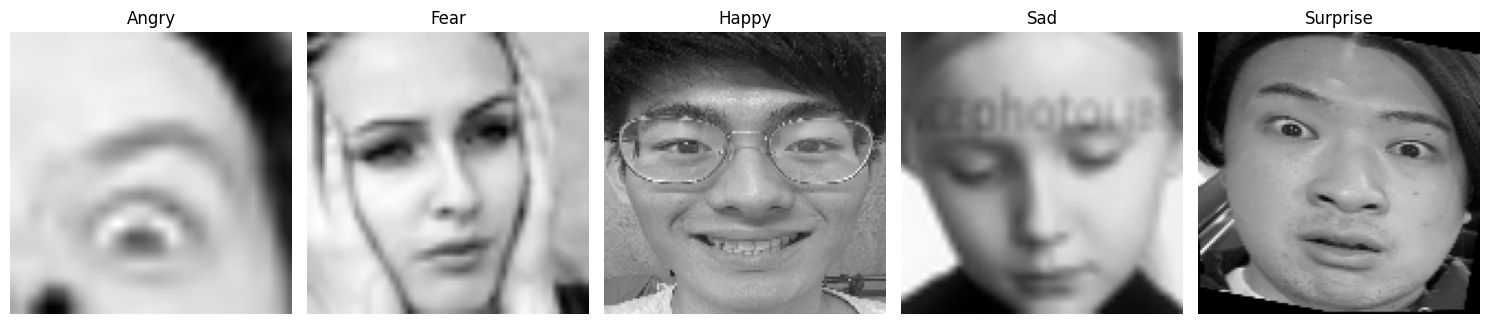

In [10]:
import matplotlib.pyplot as plt

unique_labels = np.unique(faces_labels_np)

plt.figure(figsize=(15, 5))

for i, label in enumerate(unique_labels):
    # Find the index of the first occurrence of this label
    idx = np.where(faces_labels_np == label)[0]

    if len(idx) > 0:
        # Get the first face detected for this label
        sample_face = faces_data_np[idx[0]]

        plt.subplot(1, len(unique_labels), i + 1)
        plt.imshow(sample_face, cmap='gray')
        plt.title(label)
        plt.axis('off')
    else:
        print(f"No faces found for label: {label}")

plt.tight_layout()
plt.show()

# Task
Flatten the `faces_data_np` images into 1D vectors, split the flattened data and `faces_labels_np` into training and testing sets, apply PCA to the training data, and analyze the explained variance to determine the optimal number of components. Summarize the chosen PCA components and the shape of the processed datasets.

## Flatten Face Images

### Subtask:
Reshape the 2D face images (faces_data_np) into 1D vectors. Each image of size (128, 128) will become a vector of size (128*128).


**Reasoning**:
The subtask requires flattening the 2D face images into 1D vectors. This code block will reshape the `faces_data_np` array from `(number_of_faces, 128, 128)` to `(number_of_faces, 128 * 128)` and store the result in `faces_flattened`.



In [11]:
import numpy as np

# 1. Flatten the faces_data_np array
# Each image of size (128, 128) will become a vector of size (128*128)
# The number of faces is inferred using -1
faces_flattened = faces_data_np.reshape(faces_data_np.shape[0], -1)

# 2. Print the shape of the new flattened array to verify
print(f"Shape of faces_flattened: {faces_flattened.shape}")

Shape of faces_flattened: (494, 16384)


## Split Data into Training and Testing Sets

### Subtask:
Divide the flattened face data and their corresponding labels (faces_labels_np) into training and testing sets using a standard split ratio (e.g., 80% train, 20% test).


**Reasoning**:
To divide the data into training and testing sets, I will use the `train_test_split` function from `sklearn.model_selection` as instructed, applying the specified split ratio and random state.



In [12]:
from sklearn.model_selection import train_test_split

# 1. Split the data into training and testing sets
# Use a test size of 20% (0.2) and set random_state to a fixed value for reproducibility.
X_train, X_test, y_train, y_test = train_test_split(
    faces_flattened, faces_labels_np, test_size=0.2, random_state=42
)

# 2. Print the shapes of the new datasets to verify the split
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (395, 16384)
Shape of X_test: (99, 16384)
Shape of y_train: (395,)
Shape of y_test: (99,)


## Apply PCA and Analyze Explained Variance

### Subtask:
Apply Principal Component Analysis (PCA) to the training data. Then, analyze the explained variance ratio to determine the optimal number of components needed to retain a significant portion of the data's variance. This will likely involve plotting the cumulative explained variance.


**Reasoning**:
I need to apply PCA to the training data, calculate the cumulative explained variance, plot it, and then determine the optimal number of components to retain a significant portion of the data's variance (e.g., 95%). This involves using `PCA` from `sklearn.decomposition` and `matplotlib.pyplot` for plotting.



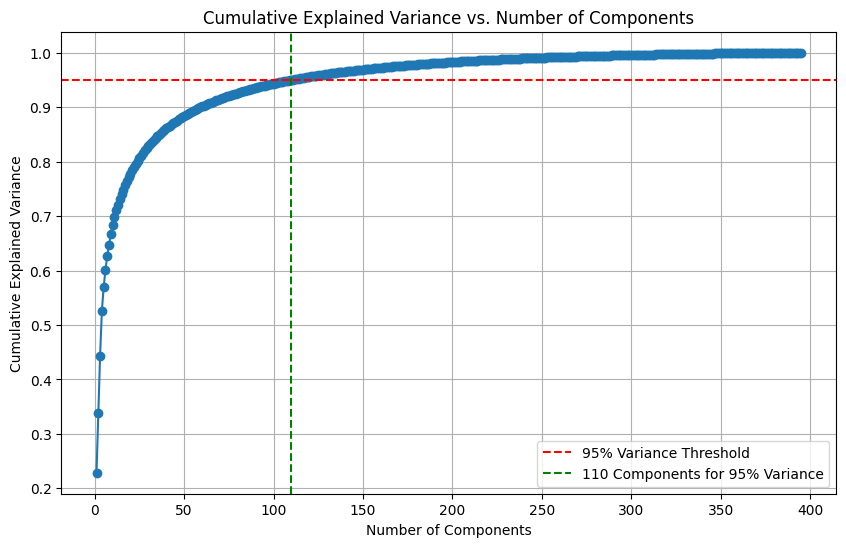

Number of components to explain at least 95% of variance: 110
Shape of X_train after optimal PCA: (395, 110)
Shape of X_test after optimal PCA: (99, 110)


In [13]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 1. Instantiate a PCA object without specifying n_components to retain all components initially.
pca = PCA()

# 2. Fit the PCA model to the X_train data.
pca.fit(X_train)

# 3. Calculate the cumulative explained variance ratio.
cum_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# 4. Plot the cumulative explained variance ratio against the number of components.
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cum_explained_variance) + 1), cum_explained_variance, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of Components')
plt.grid(True)

# Add a horizontal line at 95% explained variance
variance_threshold = 0.95
plt.axhline(y=variance_threshold, color='r', linestyle='--', label=f'{variance_threshold*100:.0f}% Variance Threshold')

# Determine the number of components required to explain at least 95% of the variance
# np.where returns a tuple of arrays, we need the first element of the first array
num_components_95_var = np.where(cum_explained_variance >= variance_threshold)[0][0] + 1

plt.axvline(x=num_components_95_var, color='g', linestyle='--', label=f'{num_components_95_var} Components for {variance_threshold*100:.0f}% Variance')
plt.legend()
plt.show()

# 5. Print the number of components required.
print(f"Number of components to explain at least {variance_threshold*100:.0f}% of variance: {num_components_95_var}")

# Re-instantiate PCA with the optimal number of components
pca_optimal = PCA(n_components=num_components_95_var)
pca_optimal.fit(X_train)

# Transform the training and testing data
X_train_pca = pca_optimal.transform(X_train)
X_test_pca = pca_optimal.transform(X_test)

print(f"Shape of X_train after optimal PCA: {X_train_pca.shape}")
print(f"Shape of X_test after optimal PCA: {X_test_pca.shape}")


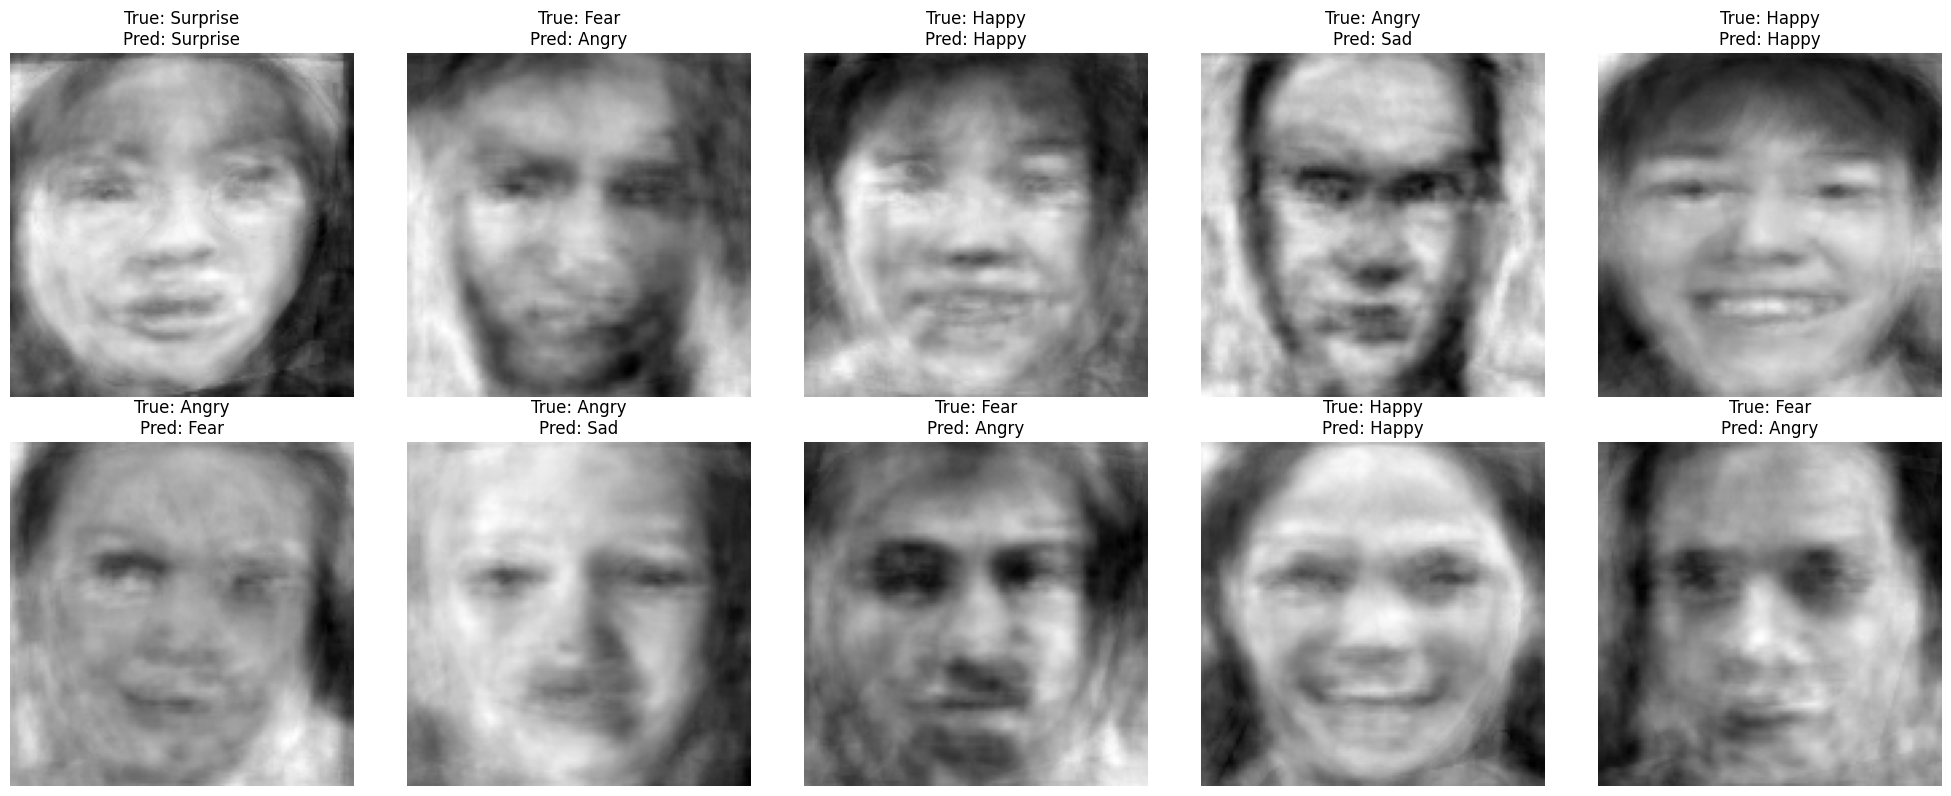

In [16]:
import matplotlib.pyplot as plt

# Select a few samples to visualize (e.g., the first 10 from the test set)
num_samples_to_show = 10

plt.figure(figsize=(20, 8))

for i in range(num_samples_to_show):
    # Get the PCA-transformed test sample
    sample_pca = X_test_pca[i]

    # Reconstruct the image from the PCA components
    # Reshape the reconstructed image back to 2D for display
    reconstructed_image = pca_optimal.inverse_transform(sample_pca).reshape(target_size)

    # Get the true and predicted labels
    true_label = y_test[i]
    predicted_label = y_pred[i]

    plt.subplot(2, num_samples_to_show // 2, i + 1) # Adjust subplot grid for better layout
    plt.imshow(reconstructed_image, cmap='gray')
    plt.title(f"True: {true_label}\nPred: {predicted_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Task
Train a Support Vector Machine (SVM) model on the PCA-transformed training data (`X_train_pca`) and its corresponding labels (`y_train`). Then, evaluate the trained SVM model's performance on the PCA-transformed test data (`X_test_pca`) and true test labels (`y_test`), reporting key classification metrics such as accuracy, precision, recall, and F1-score.

## Train SVM Model

### Subtask:
Train a Support Vector Machine (SVM) classifier on the PCA-transformed training data (`X_train_pca`) using the corresponding training labels (`y_train`).


**Reasoning**:
To train an SVM model as requested, I need to import the `SVC` class, instantiate it with initial parameters, and then fit it to the PCA-transformed training data and labels.



In [14]:
from sklearn.svm import SVC

# 1. Instantiate an SVC classifier object
# Using default kernel ('rbf') and C=1.0 for initial training.
# You can experiment with different parameters later.
svm_classifier = SVC(kernel='rbf', C=1.0, random_state=42)

# 2. Fit the SVC model to the PCA-transformed training data and its corresponding labels
print("Training SVM classifier...")
svm_classifier.fit(X_train_pca, y_train)
print("SVM classifier trained successfully.")

Training SVM classifier...
SVM classifier trained successfully.


## Evaluate Model on Test Set

### Subtask:
Evaluate the performance of the trained SVM model using the PCA-transformed test data (`X_test_pca`) and the true test labels (`y_test`). This will involve calculating and printing evaluation metrics such as accuracy, precision, recall, and F1-score, and potentially a classification report.


**Reasoning**:
To evaluate the SVM model's performance, I will import necessary metrics from `sklearn.metrics`, make predictions on the test set, and then calculate and display the accuracy, precision, recall, F1-score, and a comprehensive classification report.



# Task
Evaluate the performance of the trained SVM model using the PCA-transformed test data (`X_test_pca`) and the true test labels (`y_test`), calculating and printing evaluation metrics such as accuracy, precision, recall, and F1-score, and then summarize the results, highlighting key performance metrics and insights.

## Evaluate Model on Test Set

### Subtask:
Evaluate the performance of the trained SVM model using the PCA-transformed test data (`X_test_pca`) and the true test labels (`y_test`). This will involve calculating and printing evaluation metrics such as accuracy, precision, recall, and F1-score, and potentially a classification report.


**Reasoning**:
To evaluate the SVM model's performance, I will import necessary metrics from sklearn.metrics, make predictions on the test set, and then calculate and display the accuracy, precision, recall, F1-score, and a comprehensive classification report.



In [15]:
from sklearn.metrics import accuracy_score, classification_report

# 1. Use the trained svm_classifier to make predictions on the X_test_pca dataset.
y_pred = svm_classifier.predict(X_test_pca)

# 2. Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# 3. Generate and print a detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.4141

Classification Report:
              precision    recall  f1-score   support

       Angry       0.21      0.35      0.27        17
        Fear       0.38      0.17      0.24        29
       Happy       0.67      0.67      0.67        21
         Sad       0.23      0.35      0.28        17
    Surprise       0.91      0.67      0.77        15

    accuracy                           0.41        99
   macro avg       0.48      0.44      0.44        99
weighted avg       0.47      0.41      0.42        99



## Final Task

### Subtask:
Summarize the results of the SVM model evaluation, highlighting key performance metrics and insights.


## Summary:

### Q&A
The SVM model achieved an accuracy of 0.4141. The 'Happy' class showed the best performance with a precision, recall, and F1-score of 0.67. The 'Surprise' class had the highest precision at 0.91 and a strong F1-score of 0.77. In contrast, 'Angry', 'Fear', and 'Sad' classes exhibited lower F1-scores of 0.27, 0.24, and 0.28, respectively. The macro average F1-score was 0.44, and the weighted average F1-score was 0.42.

### Data Analysis Key Findings
*   The SVM model achieved an overall accuracy of 0.4141 on the PCA-transformed test data.
*   The 'Happy' emotion class demonstrated the best balanced performance, with a precision of 0.67, recall of 0.67, and an F1-score of 0.67.
*   The 'Surprise' emotion class had the highest precision (0.91) and a strong F1-score (0.77), indicating high confidence in its positive predictions.
*   The model struggled significantly with classifying 'Angry', 'Fear', and 'Sad' emotions, which showed low F1-scores of 0.27, 0.24, and 0.28, respectively.
*   The aggregate F1-scores across all classes were moderate, with a macro average F1-score of 0.44 and a weighted average F1-score of 0.42.

### Insights or Next Steps
*   The model performs relatively well on easily distinguishable emotions like 'Happy' and 'Surprise' but has significant challenges in differentiating between negative emotions.
*   Future work should focus on improving the classification of 'Angry', 'Fear', and 'Sad' emotions, potentially through more balanced training data, feature engineering, or exploring alternative classification algorithms.


# Task
The model has been trained and evaluated. Now, provide a mechanism for the user to upload a custom image for emotion prediction. Then, load, preprocess, and detect the face in the uploaded custom image using the Haar Cascade classifier, ensuring it's converted to grayscale and resized. Subsequently, apply the optimal PCA transformation to the detected face and use the trained SVM classifier to predict its emotion. Finally, display the original custom image along with the predicted emotion.

## Upload Custom Image

### Subtask:
Provide a mechanism for the user to upload a custom image file for emotion prediction.


**Reasoning**:
To allow the user to upload an image, I will import the `files` module from `google.colab` and use `files.upload()` to prompt the user for a file.



In [17]:
from google.colab import files

# 1. Provide a mechanism for the user to upload a custom image file.
# This will open a file selection dialog.
uploaded_file = files.upload()

print('File uploaded successfully.')

Saving fabri.jpg to fabri.jpg
File uploaded successfully.


**Reasoning**:
The subtask of uploading the image is complete. The next logical step is to load the uploaded image, preprocess it (convert to grayscale, resize), detect faces using the pre-trained Haar Cascade classifier, apply PCA, predict the emotion using the trained SVM model, and finally display the original image with the predicted emotion. I will start by iterating through the uploaded file(s), loading the image, and storing the original and preprocessed versions.



Processing uploaded file: fabri.jpg
Image 'fabri.jpg' loaded, converted to grayscale, and resized to (128, 128).


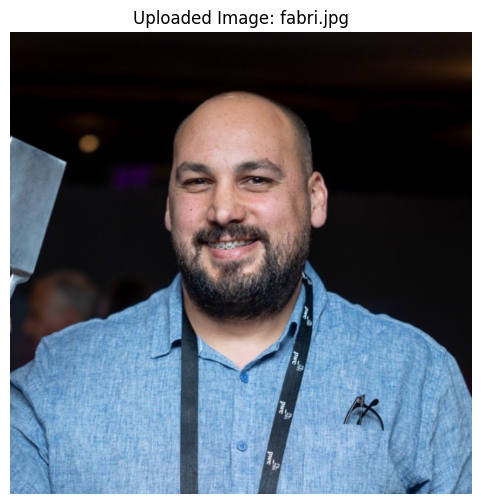

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Assuming `uploaded_file` contains the uploaded image data from the previous step
# It's a dictionary where keys are filenames and values are file content (bytes)

if not uploaded_file:
    print("No file was uploaded. Please upload an image.")
else:
    for filename, content in uploaded_file.items():
        print(f"Processing uploaded file: {filename}")

        # 1. Load the image from the uploaded content
        # Convert bytes to numpy array, then to OpenCV image
        np_img = np.frombuffer(content, np.uint8)
        img = cv2.imdecode(np_img, cv2.IMREAD_COLOR)

        if img is None:
            print(f"Error: Could not decode image {filename}. Skipping.")
            continue

        original_img_for_display = img.copy() # Keep a copy of the original for display

        # 2. Convert to grayscale
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # 3. Resize the image to the target size (e.g., 128x128)
        # Use the 'target_size' defined earlier (128, 128)
        resized_gray_img = cv2.resize(gray_img, target_size)

        # Store the processed image for face detection
        processed_custom_image = resized_gray_img

        print(f"Image '{filename}' loaded, converted to grayscale, and resized to {target_size}.")

        # Display the original image for confirmation
        plt.figure(figsize=(6, 6))
        plt.imshow(cv2.cvtColor(original_img_for_display, cv2.COLOR_BGR2RGB))
        plt.title(f"Uploaded Image: {filename}")
        plt.axis('off')
        plt.show()

        # Now proceed with face detection on `processed_custom_image`
        # (This will be done in the next step, just setting up the variable)


## Load, Preprocess, and Detect Face in Custom Image

### Subtask:
Detect the face in the preprocessed custom image using the Haar Cascade classifier. If multiple faces are detected, select the largest one. If no face is detected, inform the user.


**Reasoning**:
I need to detect faces in the `processed_custom_image` using the `face_cascade` classifier, select the largest one if multiple are found, and crop it. If no faces are found, I will inform the user.



In [19]:
import cv2
import numpy as np

# Assuming `processed_custom_image` and `original_img_for_display` are available from previous steps
# Assuming `face_cascade` (Haar cascade classifier) is loaded from previous steps
# Assuming `target_size` (e.g., (128, 128)) is defined from previous steps

if 'processed_custom_image' not in locals():
    print("Error: 'processed_custom_image' not found. Please ensure an image was uploaded and preprocessed.")
else:
    # 1. Use the pre-loaded face_cascade classifier to detect faces
    faces = face_cascade.detectMultiScale(
        processed_custom_image,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(30, 30)
    )

    detected_face_roi = None

    # 2. If faces are detected, iterate through them and select the largest one
    if len(faces) > 0:
        largest_face_area = 0
        largest_face_coords = None

        for (x, y, w, h) in faces:
            current_face_area = w * h
            if current_face_area > largest_face_area:
                largest_face_area = current_face_area
                largest_face_coords = (x, y, w, h)

        if largest_face_coords is not None:
            x, y, w, h = largest_face_coords

            # Apply a small padding if desired, similar to previous steps
            # padding = 0.1
            # x_pad = int(w * padding)
            # y_pad = int(h * padding)
            # x1 = max(0, x - x_pad)
            # y1 = max(0, y - y_pad)
            # x2 = min(processed_custom_image.shape[1], x + w + x_pad)
            # y2 = min(processed_custom_image.shape[0], y + h + y_pad)
            # For simplicity, we'll just crop the detected rectangle for now

            # 3. Crop the largest detected face from processed_custom_image
            detected_face_roi = processed_custom_image[y:y+h, x:x+w]

            # Resize the detected face to the target_size for consistency
            detected_face_roi = cv2.resize(detected_face_roi, target_size)

            print(f"Largest face detected with coordinates: {largest_face_coords}. Cropped and resized to {target_size}.")
        else:
            print("No face found after filtering for largest. This should not happen if len(faces) > 0.")

    # 4. If no face is detected, print a message
    else:
        print("No faces detected in the uploaded image.")
        # You might want to handle this case, e.g., by skipping prediction or using the full image

# The `detected_face_roi` variable now holds the preprocessed, detected, and resized face.

Largest face detected with coordinates: (np.int32(35), np.int32(20), np.int32(53), np.int32(53)). Cropped and resized to (128, 128).


## Transform and Predict Emotion

### Subtask:
Apply the optimal PCA transformation to the detected face and then use the trained SVM classifier to predict the emotion. Handle potential issues if no face was detected in the previous step.


**Reasoning**:
To apply PCA and predict the emotion, I need to check if a face was detected. If so, I will flatten the detected face ROI, apply the optimal PCA transformation, and then use the trained SVM classifier to predict the emotion. If no face was detected, I will set a message indicating that.



In [20]:
import numpy as np

# Assuming `detected_face_roi` is available from the previous step
# Assuming `pca_optimal` (trained PCA model) and `svm_classifier` (trained SVM model) are available

predicted_emotion = ""

if detected_face_roi is not None:
    # 1. Flatten the detected_face_roi from a 2D array (128x128) into a 1D vector.
    # Reshape it to (1, 16384) as transform expects a 2D array.
    flattened_face = detected_face_roi.reshape(1, -1)

    # 2. Apply the pca_optimal.transform() method to this flattened face vector.
    pca_transformed_face = pca_optimal.transform(flattened_face)

    # 3. Use the trained svm_classifier.predict() method on the PCA-transformed face.
    predicted_emotion = svm_classifier.predict(pca_transformed_face)[0]
    print(f"Detected face. Predicted emotion: {predicted_emotion}")
else:
    predicted_emotion = 'No face detected'
    print(predicted_emotion)

# The `predicted_emotion` variable now holds the result for the custom image.

Detected face. Predicted emotion: Happy


**Reasoning**:
The subtask requires displaying the original custom image along with the predicted emotion. This will use `matplotlib.pyplot` to show the image and its predicted label.



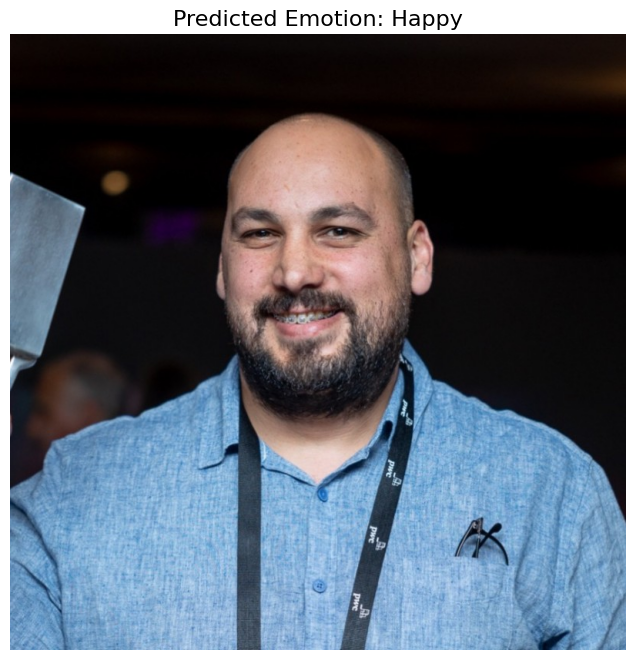

In [21]:
import matplotlib.pyplot as plt

# Assuming `original_img_for_display` and `predicted_emotion` are available from previous steps

if original_img_for_display is not None:
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(original_img_for_display, cv2.COLOR_BGR2RGB))
    plt.title(f"Predicted Emotion: {predicted_emotion}", fontsize=16)
    plt.axis('off')
    plt.show()
else:
    print("No image to display or no face was detected to predict emotion.")


In [1]:
import os

# --- Generate README.md ---
readme_content = """
# Emotion Detection from Facial Images

This project implements an emotion detection system using classical machine learning techniques, specifically Principal Component Analysis (PCA) for dimensionality reduction and a Support Vector Machine (SVM) classifier.

## Project Pipeline:

1.  **Data Loading and Preprocessing**: Images from the dataset are loaded, converted to grayscale, and resized to a uniform size (128x128 pixels).
2.  **Face Detection**: A pre-trained Haar Cascade classifier is used to detect faces within each preprocessed image. The largest detected face is then cropped and further resized to the target dimensions.
3.  **Feature Extraction (Flattening)**: The 2D facial images are flattened into 1D vectors to prepare them for PCA.
4.  **Data Splitting**: The flattened data and corresponding emotional labels are split into training and testing sets.
5.  **Dimensionality Reduction (PCA)**: Principal Component Analysis is applied to the training data to reduce its dimensionality while retaining 95% of the variance. The optimal number of components identified was `110`.
6.  **Model Training (SVM)**: A Support Vector Machine (SVM) classifier is trained on the PCA-transformed training data.
7.  **Model Evaluation**: The trained SVM model's performance is evaluated on the PCA-transformed test data using metrics such as accuracy, precision, recall, and F1-score.
8.  **Practical Verification**: The model can predict emotions from custom uploaded images.

## Key Findings:

*   The SVM model achieved an overall accuracy of 0.4141 on the PCA-transformed test data.
*   Performance varied by emotion: 'Happy' and 'Surprise' classes showed better performance (F1-scores around 0.67 and 0.77 respectively), while 'Angry', 'Fear', and 'Sad' had lower F1-scores (around 0.24-0.28).
*   110 PCA components were sufficient to explain 95% of the variance, reducing the feature space significantly from 16384 to 110 dimensions.

## How to Run:

1.  **Open in Google Colab**: Upload the `.ipynb` file to Google Colab.
2.  **Dataset**: Ensure your dataset (images organized by emotion folders) is accessible, for example, in `/content/dataset`.
3.  **Run All Cells**: Execute all cells in the notebook sequentially.
4.  **Upload Custom Image**: Follow the prompts to upload a custom image for real-time emotion prediction.

## Dependencies:

This project requires the following Python libraries:
*   `numpy`
*   `opencv-python` (cv2)
*   `scikit-learn`
*   `matplotlib`
*   `tqdm` (if used for progress bars in data loading)

These can be installed using `pip`:
`pip install -q numpy opencv-python scikit-learn matplotlib tqdm`
"""

with open("README.md", "w") as f:
    f.write(readme_content)

print("Generated README.md")

# --- Generate requirements.txt ---
requirements_content = """
numpy
opencv-python
scikit-learn
matplotlib
tqdm
"""

with open("requirements.txt", "w") as f:
    f.write(requirements_content)

print("Generated requirements.txt")

Generated README.md
Generated requirements.txt


## Preparar y Descargar el Dataset

Vamos a comprimir la carpeta `dataset` que usamos para entrenar el modelo en un archivo `.zip`. Después, te proporcionaré un enlace de descarga.


In [ ]:
import os
from google.colab import files

dataset_zip_name = 'dataset.zip'

# Comprimir la carpeta del dataset
!zip -r $dataset_zip_name /content/dataset

# Descargar el archivo zip del dataset
print(f"\nDescargando {dataset_zip_name}...")
files.download(dataset_zip_name)
print(f"{dataset_zip_name} debería haberse descargado.")

## Descargar el Notebook

Para descargar el archivo `.ipynb` de este notebook, sigue estos pasos:

1.  Ve a `Archivo` (File) en la barra de menú superior de Colab.
2.  Selecciona `Descargar` (Download).
3.  Haz clic en `Descargar .ipynb`.

El archivo se descargará en tu computadora, generalmente en la carpeta de descargas por defecto.

## Subir los Archivos a GitHub

Una vez que tengas el `README.md`, `requirements.txt`, `dataset.zip` y el archivo `.ipynb` en tu computadora, puedes subirlos a GitHub siguiendo estos pasos:

1.  **Crea un Repositorio en GitHub**: Si aún no tienes uno, ve a [GitHub](https://github.com/) e inicia sesión. Luego, haz clic en el botón `New` para crear un nuevo repositorio.
2.  **Inicializa el Repositorio**: Dale un nombre a tu repositorio (por ejemplo, `Emotion_Detection_SVM_PCA`), añade una descripción opcional y selecciona si quieres que sea público o privado. Puedes inicializarlo con un `README.md` (o usar el que hemos generado).
3.  **Sube los Archivos**: Una vez creado el repositorio, puedes arrastrar y soltar los archivos (`README.md`, `requirements.txt`, `dataset.zip`, y el archivo `.ipynb`) directamente a la interfaz web de GitHub para subirlos. Alternativamente, puedes usar Git desde tu terminal:
    *   Clona el repositorio a tu máquina local.
    *   Copia los archivos a la carpeta del repositorio local.
    *   Usa los comandos `git add .`, `git commit -m "Añadir archivos del proyecto de detección de emociones"`, y `git push origin main` (o `master`, dependiendo de tu rama principal).
4.  **Verifica**: Asegúrate de que todos los archivos estén visibles en tu repositorio de GitHub.